# Load Data

In [1]:
save_plots = True

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import special
from inspect import signature
from datetime import datetime
import time
from tqdm import tqdm
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as md

In [3]:
## Set plot styles

%matplotlib inline
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.linewidth'] = 0.75 #set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.75
matplotlib.rcParams['ytick.major.width'] = 0.75
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['legend.fontsize'] =5
matplotlib.rcParams['pdf.fonttype']=42


matplotlib.rcParams['figure.figsize'] = (3.4908516673585166, 2.327234444905678)
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rc('font', size= 7)
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)

/home/alex/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [4]:
!ls /home/alex/PhD/Gator/Data/Alumina_96perc_202105/

Alumina_96perc_202105_000.SPE  Alumina_96perc_202105_060.SPE
Alumina_96perc_202105_001.SPE  Alumina_96perc_202105_061.SPE
Alumina_96perc_202105_002.SPE  Alumina_96perc_202105_062.SPE
Alumina_96perc_202105_003.SPE  Alumina_96perc_202105_063.SPE
Alumina_96perc_202105_004.SPE  Alumina_96perc_202105_064.SPE
Alumina_96perc_202105_005.SPE  Alumina_96perc_202105_065.SPE
Alumina_96perc_202105_006.SPE  Alumina_96perc_202105_066.SPE
Alumina_96perc_202105_007.SPE  Alumina_96perc_202105_067.SPE
Alumina_96perc_202105_008.SPE  Alumina_96perc_202105_068.SPE
Alumina_96perc_202105_009.SPE  Alumina_96perc_202105_069.SPE
Alumina_96perc_202105_010.SPE  Alumina_96perc_202105_070.SPE
Alumina_96perc_202105_011.SPE  Alumina_96perc_202105_071.SPE
Alumina_96perc_202105_012.SPE  Alumina_96perc_202105_072.SPE
Alumina_96perc_202105_013.SPE  Alumina_96perc_202105_073.SPE
Alumina_96perc_202105_014.SPE  Alumina_96perc_202105_074.SPE
Alumina_96perc_202105_015.SPE  Alumina_96perc_202105_075.SPE
Alumina_96perc_202105_01

In [5]:
path = '/home/alex/PhD/Gator/Data/Alumina_96perc_202105/'
files_list = glob.glob(path+'Alumina_96perc_202105*')

sample_name = 'HV Feedthrough Alumina (96%)'
filename_suffix_save = 'plots/Alumina_202105'

## Remove outliers
try:
    #files_list.remove(path+'Alumina_96perc_202105_011.SPE')
    files_list.remove(path+'Alumina_96perc_202105_000.SPE')
    files_list.remove(path+'Alumina_96perc_202105_001.SPE')
    files_list.remove(path+'Alumina_96perc_202105_002.SPE')
    files_list.remove(path+'Alumina_96perc_202105_003.SPE')
    files_list.remove(path+'Alumina_96perc_202105_004.SPE')
    files_list.remove(path+'Alumina_96perc_202105_005.SPE')
    files_list.remove(path+'Alumina_96perc_202105_006.SPE')
    files_list.remove(path+'Alumina_96perc_202105_007.SPE')
    files_list.remove(path+'Alumina_96perc_202105_008.SPE')
    files_list.remove(path+'Alumina_96perc_202105_009.SPE')
    files_list.remove(path+'Alumina_96perc_202105_010.SPE')
    files_list.remove(path+'Alumina_96perc_202105_011.SPE')
    files_list.remove(path+'Alumina_96perc_202105_012.SPE')
    files_list.remove(path+'Alumina_96perc_202105_013.SPE')
    files_list.remove(path+'Alumina_96perc_202105_014.SPE')
    files_list.remove(path+'Alumina_96perc_202105_015.SPE')
    files_list.remove(path+'Alumina_96perc_202105_016.SPE')
    files_list.remove(path+'Alumina_96perc_202105_017.SPE')
    files_list.remove(path+'Alumina_96perc_202105_053.SPE')
    files_list.remove(path+'Alumina_96perc_202105_095.SPE')
except:
    print('Skipped.')

In [6]:
def load_file(file):
    number_lines_header = 12 ## There are 12 header lines in the SPE file
    counts_list = []

    with open(file) as fp:
        for i, line in enumerate(fp):
            line = line.rstrip('\n')
            if i == 1: ## description of the sample
                descr = line
                #print(descr)
            elif i == 7: ## starting acquisition time
                string_time = line
                #print(string_time)
                # TODO: convert to UNIX time
            elif i == 9: ## acquisition time
                live_time = int(line.split(' ')[0]) ## acquisition live time in seconds (without dead time)
                real_time = int(line.split(' ')[1]) ## acquisition real time in seconds
                #print(live_time, real_time)
            elif i == 11: ## channel numbers
                first_channel = int(line.split(' ')[0]) ## number of first channel, usually 0
                last_channel = int(line.split(' ')[1]) ## number of last channel, usually 16383 (= 2^14-1)
                #print(first_channel, last_channel)
            elif (i >= number_lines_header):
                if (i<=last_channel+number_lines_header):
                    counts_list.append(int(line))
                elif i > last_channel+number_lines_header:
                    break

    channels_list = np.arange(0, last_channel+1)
    df = pd.DataFrame(data={'channel': channels_list, 'counts': counts_list})
    
    return df, live_time, string_time, descr

def load_files(files_list):
    for i_file, file in enumerate(files_list):
        if i_file == 0:
            df_combined, live_time_combined = load_file(file)[0:2]
        else:
            df_temp, live_time_temp = load_file(file)[0:2]
            if len(df_combined) == len(df_temp):
                df_combined.counts = df_combined.counts + df_temp.counts
                live_time_combined = live_time_combined + live_time_temp
            else:
                raise ValueError("file "+str(file)+" has different number of channels compared to previous file")
                
    print('total live time = '+str(live_time_combined)+' s = '+str(live_time_combined/(24*60*60))+' d')
    return df_combined, live_time_combined

In [7]:
df, total_live_time = load_files(files_list)
df

total live time = 1425598 s = 16.49997685185185 d


,channel,counts
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
16379,16379,0
16380,16380,0
16381,16381,0
16382,16382,0


In [8]:
## Trigger Rate [s^-1]
df.loc[545:16380].counts.sum()/total_live_time

0.6354533325664037

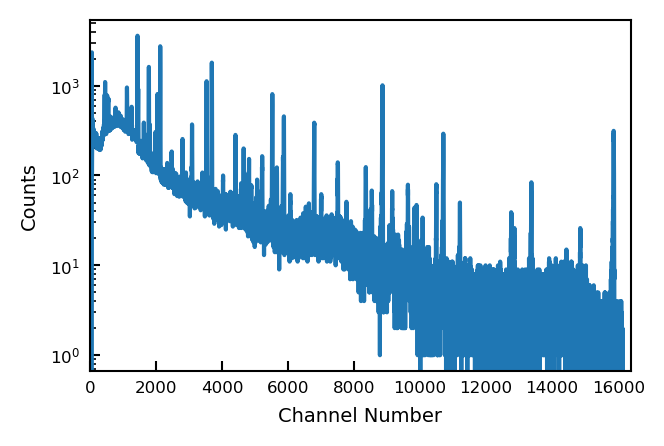

In [9]:
plt.plot(df.channel, df.counts)
plt.yscale('log')
plt.xlim(0,16383)
#plt.ylim(bottom = 30)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
plt.show()

# Fit Individual Peaks

In [10]:
def gausFunc(E, Gamma,P,sigma,C):
    gaus = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + C
    return gaus

#def tailFunc(E, Gamma,P,sigma,beta,C):
#    tail = Gamma * np.exp((E-P)/beta)*special.erfc(((E-P)/beta)+(sigma/(np.sqrt(2)*beta))) + C
#    return tail

from scipy.stats import crystalball
def crystalballFunc(E, Gamma,P,sigma,alpha,n,C):
    ## https://scipy.github.io/devdocs/generated/scipy.stats.crystalball.html
    crys = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + C
    return crys

def stepFunc(E, S,P,sigma,C):
    step = S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return step

def linFunc(E, m,q):
    lin = m*E+q
    return lin

def gausStepFunc(E, Gamma,S,P,sigma,C):
    gausStep = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return gausStep

def fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q
    return res

In [11]:
df_calibration = pd.DataFrame(data={'name': [], 'e_lit': [], 'e_err_lit': [], 
                                    'peak_position': [], 'peak_position_unc': [], 
                                    'peak_width': [], 'peak_width_unc': [], 
                                    'chi2_dof': [], 'channel_max': []})

## Pb238

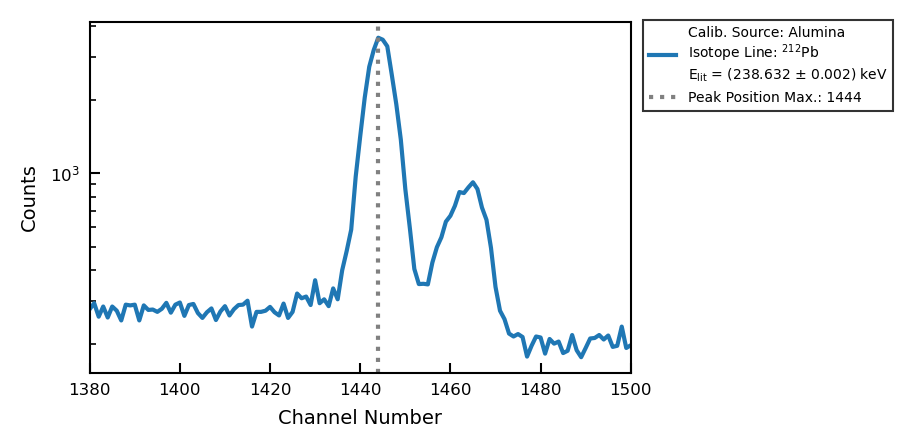

In [12]:
name = 'Pb238'
isotope = '$^{212}$Pb'
e_lit = 238.632 #keV
e_err_lit = 0.002 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1380
upper_channel = 1500
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [13]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = 0
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-0.1,0.1]
limits_q = [-np.inf,+np.inf]

In [14]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

[ 2.54340342e+04  1.44442606e+03  3.05025519e+00  6.23297713e+02
  3.07770095e+02  3.07248902e+00 -1.00000000e-01  4.13965671e+02]


/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


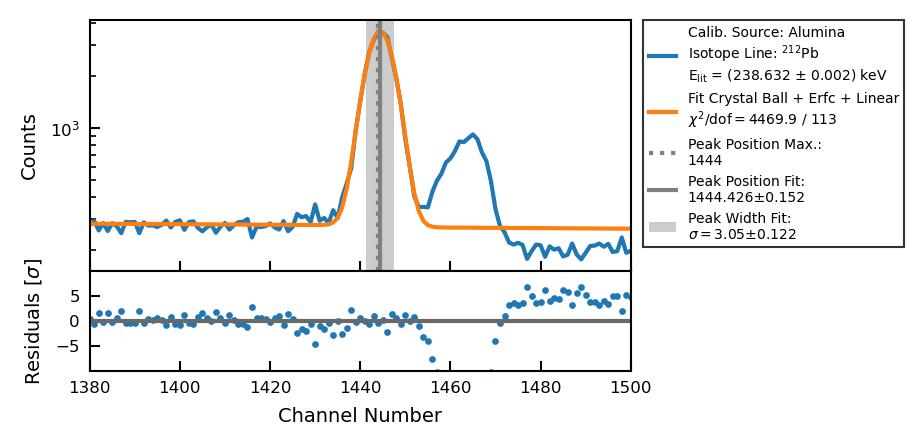

In [15]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
#yticks[-1].label1.set_visible(False)
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

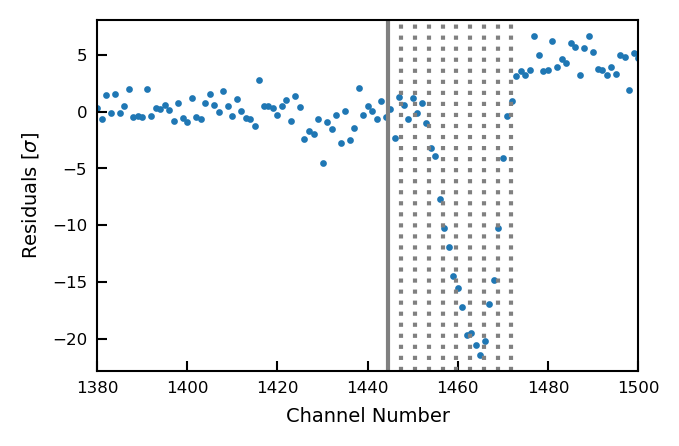

In [16]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
for i in range(1,10):
    plt.axvline(peak_position+i*peak_width, linestyle='dotted', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

**Comment:** little peak from Ra-224 at ~240keV above Pb-212 peak affects the fit -> add additional Gaussian with clever fit constraints.

In [17]:
def fitFunc238(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2)))
    return res

In [18]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,_,_,_ = popt
#guess_sigma = popt[2]

guess_P2 = popt[1] + 5*popt[2]
guess_Gamma2 = (val_max - high_med)/10
guess_sigma2 = popt[2]

limits_P2 = [popt[1] + 3*popt[2], min(popt[1]+7*popt[2], upper_channel)]
limits_Gamma2 = [1, (val_max - high_med)/2]
limits_sigma2 = [0.5, min(2*popt[2], 100,(upper_channel-lower_channel)/2)]

In [19]:
## Total Fit
popt, pcov = curve_fit(fitFunc238, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[2.59317104e+04 1.44449414e+03 3.08651392e+00 2.27849946e+02
 7.99909418e+02 4.44047088e+01 1.00000000e-01 4.95950644e+01
 6.92862383e+02 1.46309550e+03 4.38708530e+00]
Appending data for Pb238 to df_calibration.


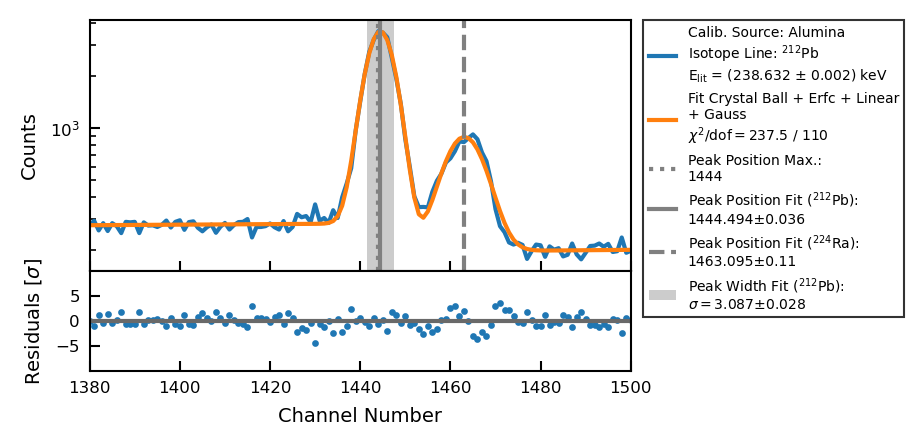

In [20]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc238(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{224}$Ra):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)

if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
    
plt.show()

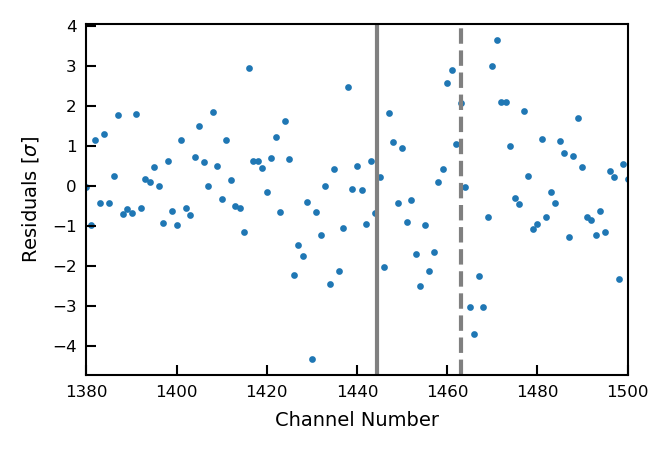

In [21]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
plt.axvline(peak2_position, linestyle='dashed', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

## Tl 583

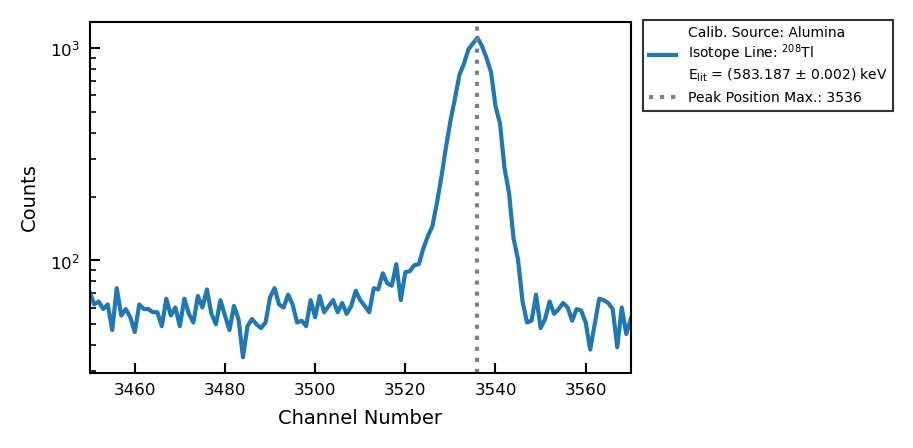

In [22]:
name = 'Tl583'
isotope = '$^{208}$Tl'
e_lit = 583.187 #keV
e_err_lit = 0.002 #keV

#######################
## Adjust these values if necessary:
lower_channel = 3450
upper_channel = 3570
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [23]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [24]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 9.96518511e+03  3.53541217e+03  3.92710165e+00  2.30160704e+02
  9.37712097e+02  1.25000000e+01  2.40741763e-01 -8.03697139e+02]
Appending data for Tl583 to df_calibration.


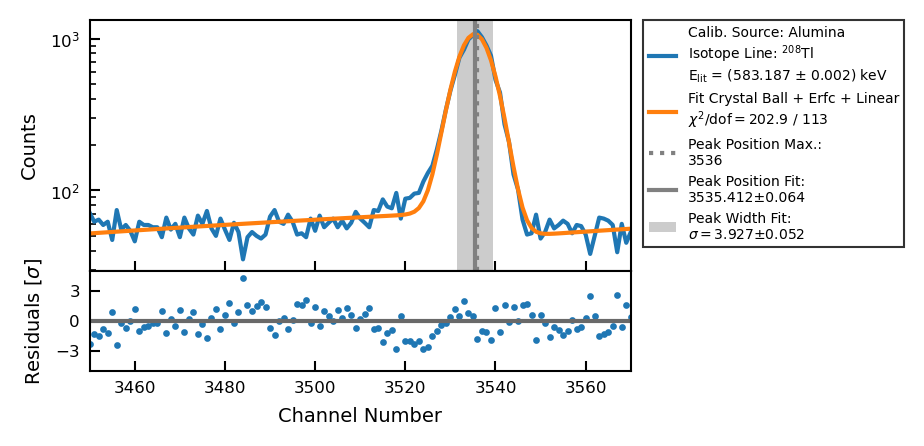

In [25]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 1120

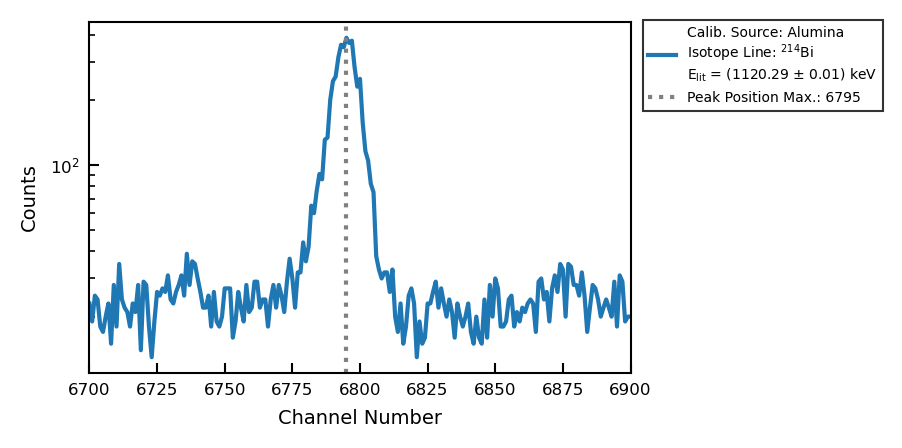

In [26]:
name = 'Bi1120'
isotope = '$^{214}$Bi'
e_lit = 1120.29 #keV
e_err_lit = 0.01 # guess, what is correct???????? #keV

#######################
## Adjust these values if necessary:
lower_channel = 6700
upper_channel = 6900
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [27]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [28]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 4.25384366e+03  6.79469476e+03  5.03259507e+00  5.53893414e+02
  7.48227157e+02  3.75000000e+00  5.27997568e-02 -3.39855807e+02]
Appending data for Bi1120 to df_calibration.


/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


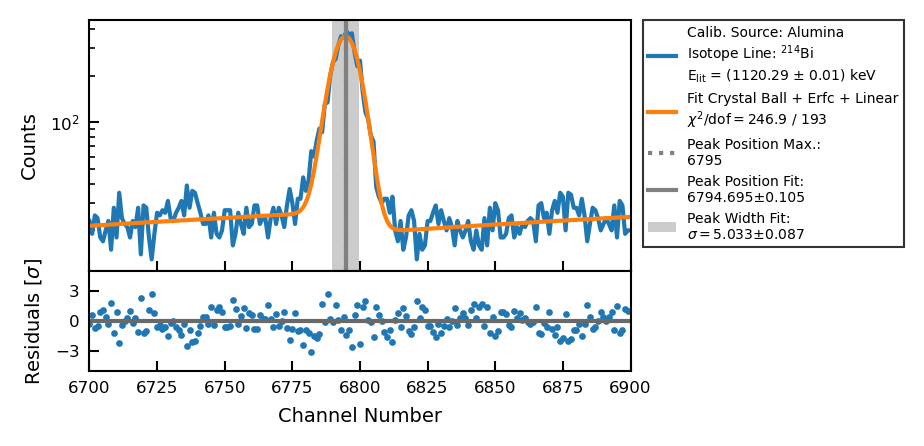

In [29]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')

plt.subplots_adjust(hspace=.0)
plt.show()

## Tl 860

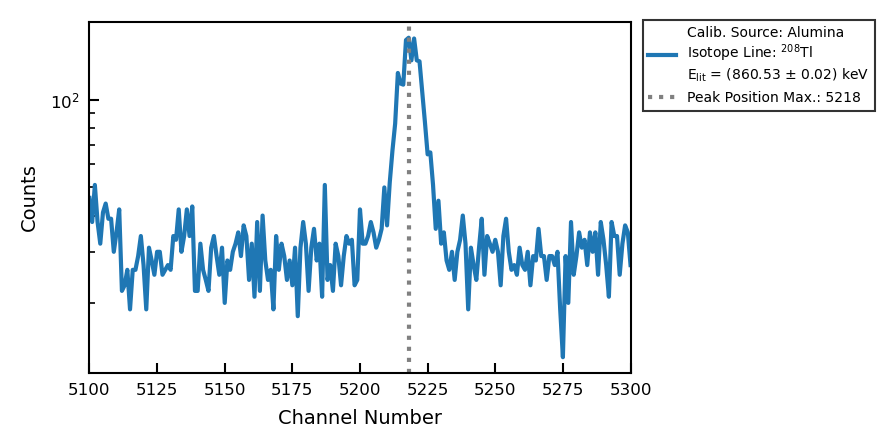

In [30]:
name = 'Tl860'
isotope = '$^{208}$Tl'
e_lit = 860.53 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 5100
upper_channel = 5300
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [31]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [32]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 1.39150519e+03  5.21865250e+03  4.36491706e+00  2.66196471e+02
  2.45070525e+02 -6.12605627e-01 -1.55202167e-02  1.10114317e+02]
Appending data for Tl860 to df_calibration.


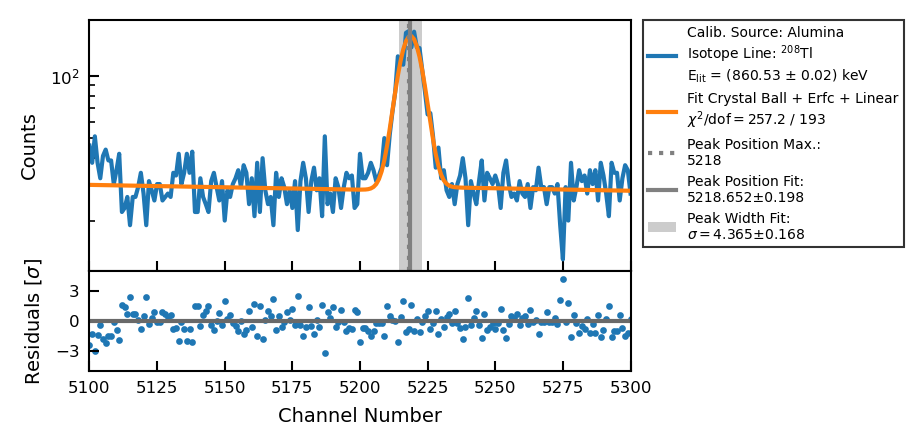

In [33]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Tl 2614

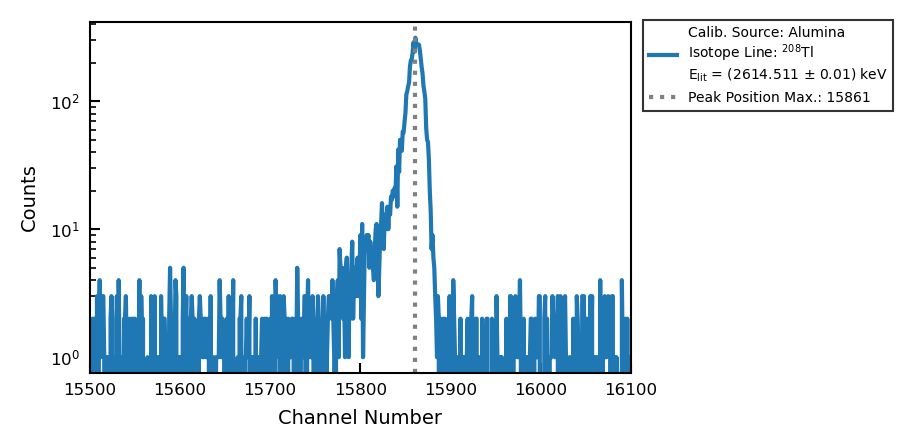

In [34]:
name = 'Tl2614'
isotope = '$^{208}$Tl'
e_lit = 2614.511 #keV
e_err_lit = 0.010 #keV

#######################
## Adjust these values if necessary:
lower_channel = 15500
upper_channel = 16100
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [35]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.05, 1000]
limits_n = [0.01, 1000]
limits_S = [-2*guess_S-0.01,2*guess_S+0.01]
limits_m = [-np.inf,0]
limits_q = [-np.inf,+np.inf]

In [36]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 5.60209877e+03  1.58616941e+04  6.71575168e+00  1.22041310e+00
  2.55940632e+00 -9.99999842e-03 -4.28616273e-14  7.39230321e-01]
Appending data for Tl2614 to df_calibration.


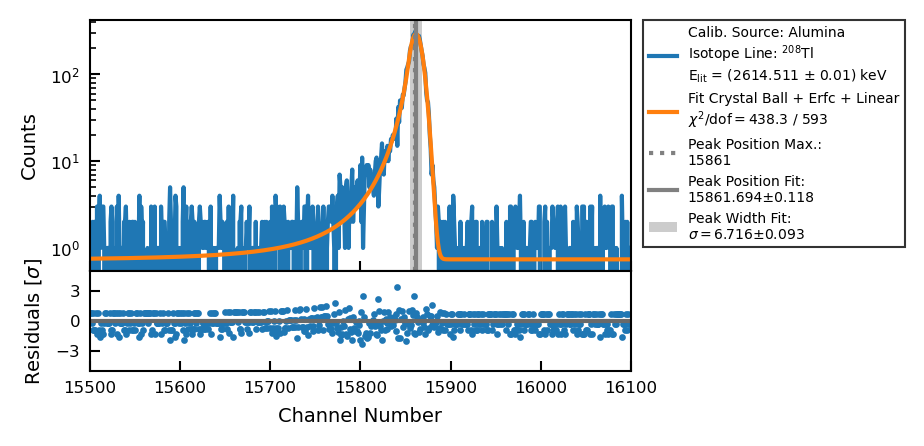

In [37]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 1764

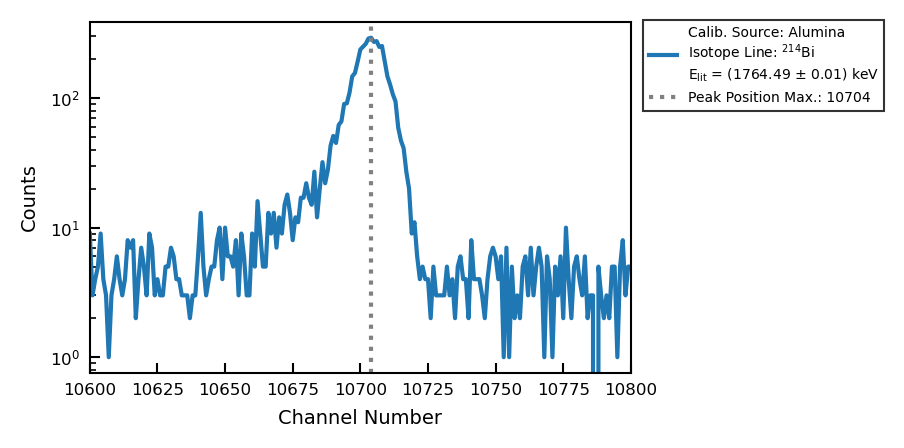

In [38]:
name = 'Bi1764'
isotope = '$^{214}$Bi'
e_lit = 1764.49 #keV
e_err_lit = 0.01 # guess, what is correct????????  #keV

#######################
## Adjust these values if necessary:
lower_channel = 10600
upper_channel = 10800
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [39]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,0]
limits_q = [-np.inf,+np.inf]

In [40]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 4.60401240e+03  1.07039254e+04  5.73930607e+00  1.27751787e+00
  2.47754052e+00 -5.36954636e-01 -7.91207267e-03  8.81183542e+01]
Appending data for Bi1764 to df_calibration.


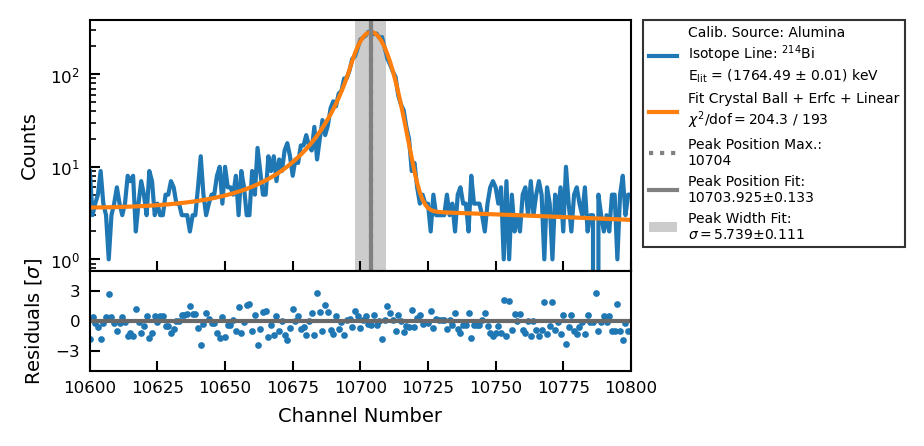

In [41]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')

plt.subplots_adjust(hspace=.0)
plt.show()

## K 1460

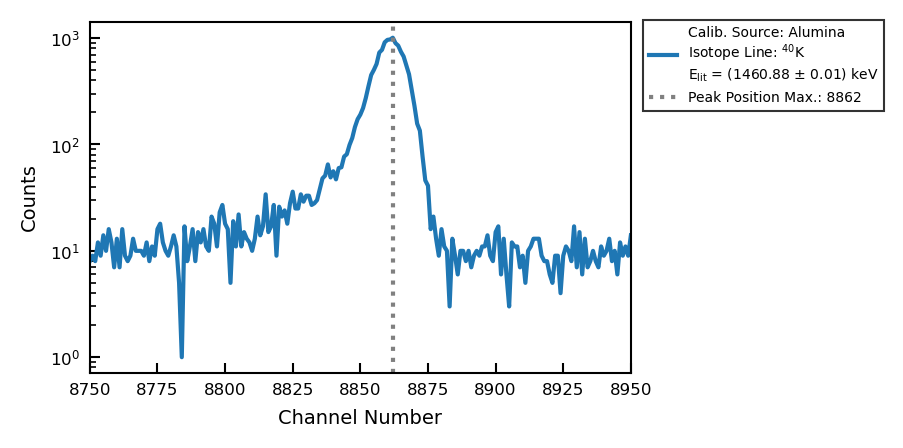

In [42]:
name = 'K1460'
isotope = '$^{40}$K'
e_lit = 1460.88 #keV
e_err_lit = 0.01 # guess, what is correct????????  #keV

#######################
## Adjust these values if necessary:
lower_channel = 8750
upper_channel = 8950
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [43]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [44]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 1.44396921e+04  8.86113963e+03  5.21785532e+00  1.24464068e+00
  2.75820673e+00  5.10733863e-01  1.37844305e-02 -1.14478781e+02]
Appending data for K1460 to df_calibration.


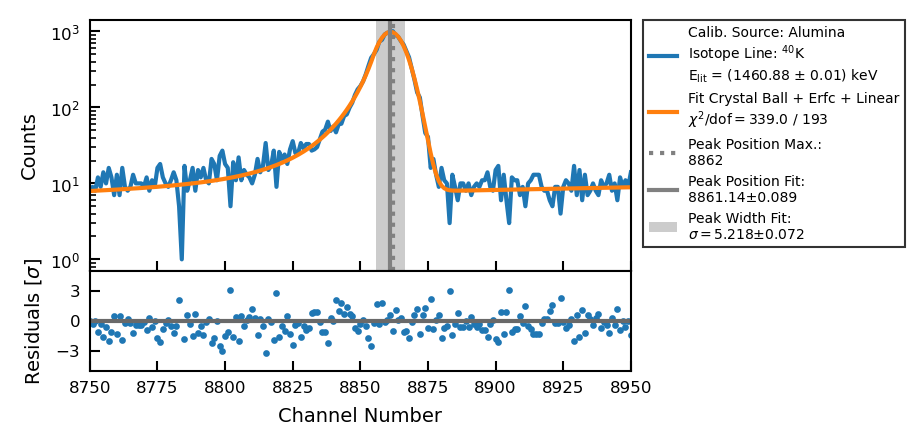

In [45]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')

plt.subplots_adjust(hspace=.0)
plt.show()

## U 185

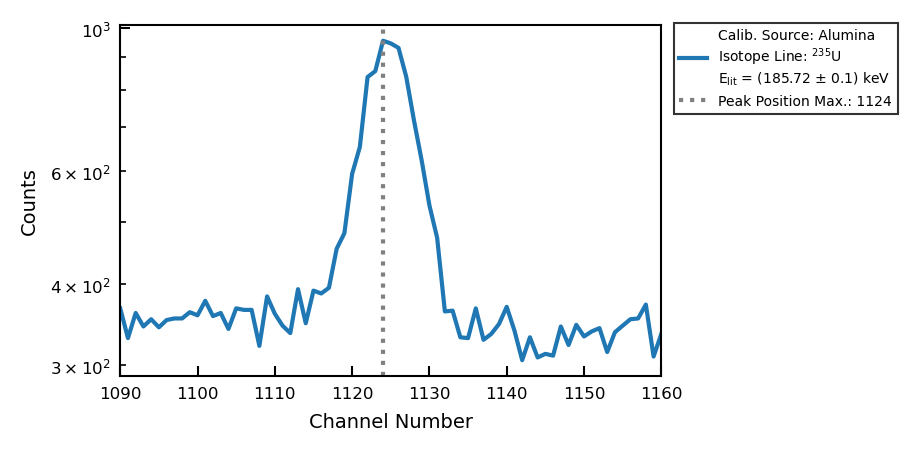

In [46]:
name = 'U185'
isotope = '$^{235}$U'
e_lit = 185.72 #keV
e_err_lit = 0.1 # guess, what is correct????????  #keV

#######################
## Adjust these values if necessary:
lower_channel = 1090
upper_channel = 1160
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [47]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [48]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[5.21425679e+03 1.12482447e+03 3.38113330e+00 3.78291481e+02
 1.03875315e+02 1.75000000e+01 2.88384727e-01 2.71853183e+00]
Appending data for U185 to df_calibration.


/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


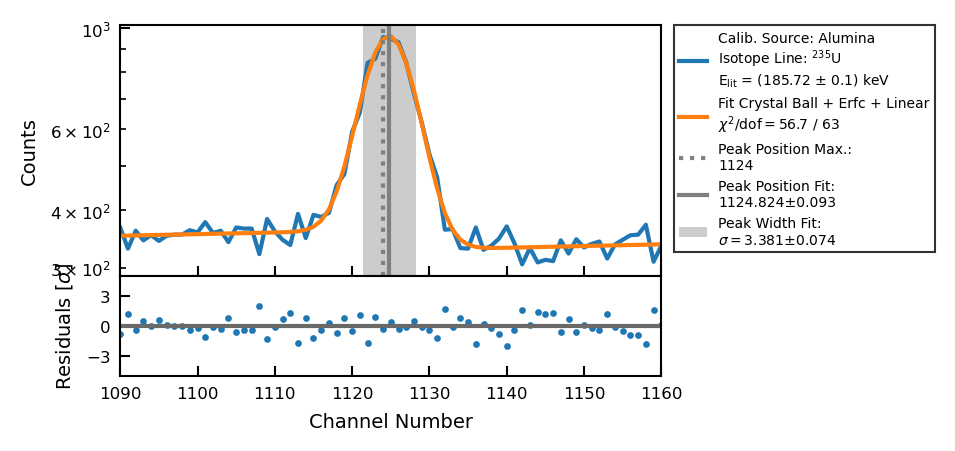

In [49]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')

plt.subplots_adjust(hspace=.0)
plt.show()

## Ac 338

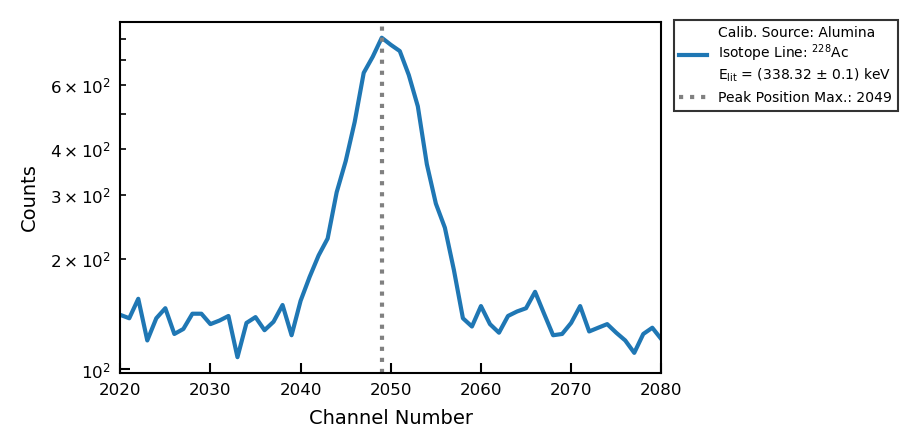

In [50]:
name = 'Ac338'
isotope = '$^{228}$Ac'
e_lit = 338.32 #keV
e_err_lit = 0.1 # guess, what is correct????????  #keV

#######################
## Adjust these values if necessary:
lower_channel = 2020
upper_channel = 2080
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [51]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [52]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 5.42113505e+03  2.04947826e+03  3.27850720e+00  8.18487902e+02
  9.99807870e+02 -3.85659385e+00 -3.15932456e-01  7.84852926e+02]
Appending data for Ac338 to df_calibration.


/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:8296: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


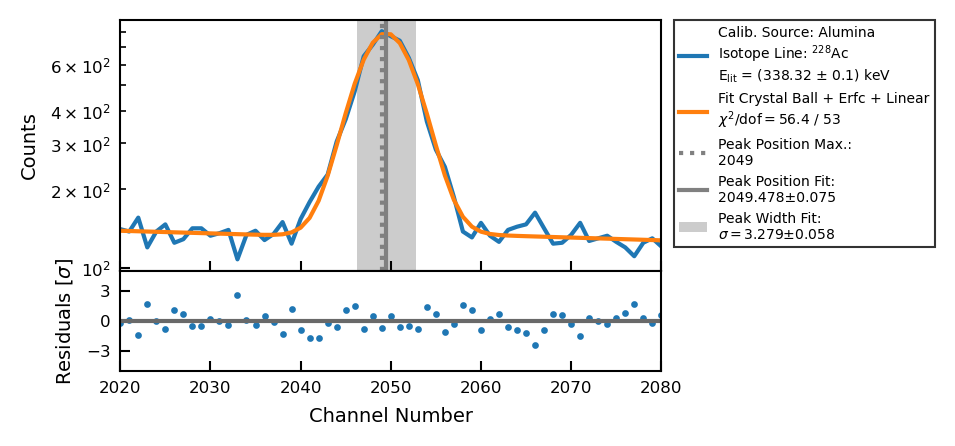

In [53]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')

plt.subplots_adjust(hspace=.0)
plt.show()

## Bi 2204

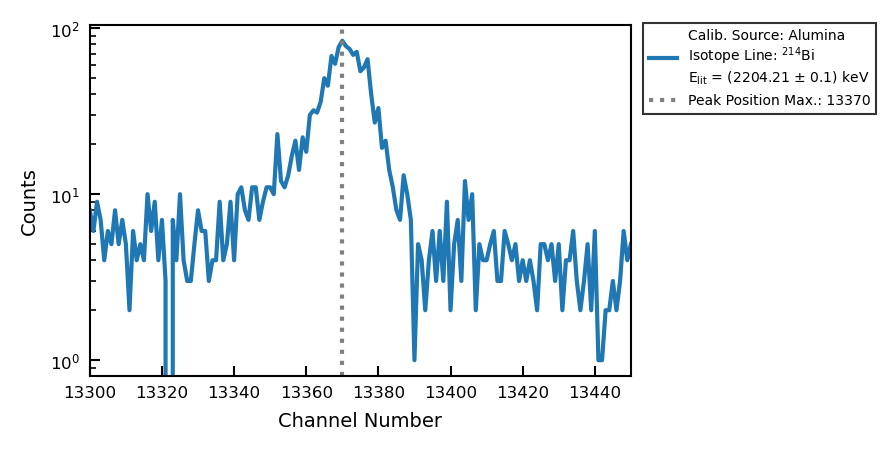

In [54]:
name = 'Bi2204'
isotope = '$^{214}$Bi'
e_lit = 2204.21 #keV
e_err_lit = 0.1 # guess, what is correct????????  #keV

#######################
## Adjust these values if necessary:
lower_channel = 13300
upper_channel = 13450
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [55]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 100]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [56]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 1.28376352e+03  1.33712913e+04  5.72757320e+00  8.72398220e-01
  4.57086261e+00 -1.22497790e+00 -2.78491596e-02  3.77012419e+02]
Appending data for Bi2204 to df_calibration.


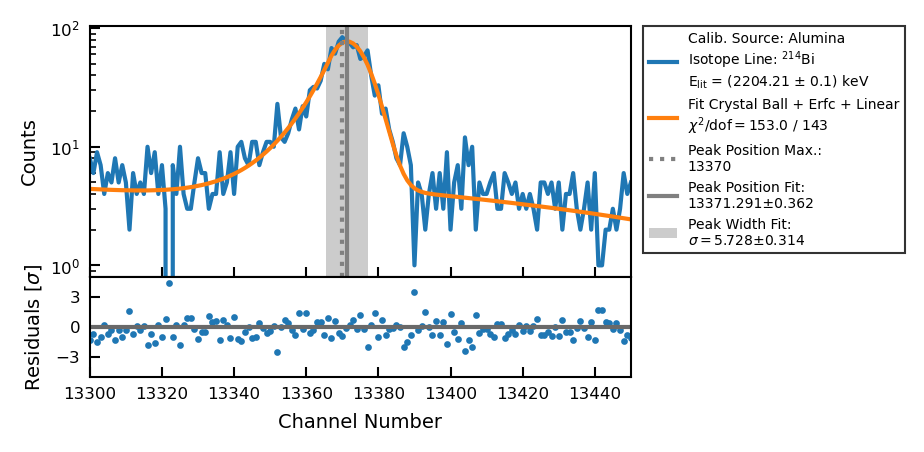

In [57]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: Alumina\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')

plt.subplots_adjust(hspace=.0)
plt.show()

# Quality Checks

In [58]:
df_calibration.sort_values(by=['e_lit'], inplace=True)
df_calibration= df_calibration.reset_index(drop=True)

In [59]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max
0,U185,185.720,0.100,1124.824470,0.093404,3.381133,0.074480,0.900446,1124.0
1,Pb238,238.632,0.002,1444.494135,0.035791,3.086514,0.028334,2.159122,1444.0
2,Ac338,338.320,0.100,2049.478264,0.075015,3.278507,0.057991,1.064492,2049.0
3,Tl583,583.187,0.002,3535.412165,0.063706,3.927102,0.051598,1.796012,3536.0
4,Tl860,860.530,0.020,5218.652499,0.198383,4.364917,0.168316,1.332821,5218.0
5,Bi1120,1120.290,0.010,6794.694760,0.105410,5.032595,0.086916,1.279259,6795.0
6,K1460,1460.880,0.010,8861.139627,0.088668,5.217855,0.071575,1.756352,8862.0
7,Bi1764,1764.490,0.010,10703.925356,0.132503,5.739306,0.111216,1.058552,10704.0
8,Bi2204,2204.210,0.100,13371.291317,0.362399,5.727573,0.313913,1.069671,13370.0
9,Tl2614,2614.511,0.010,15861.694141,0.117573,6.715752,0.092877,0.739170,15861.0


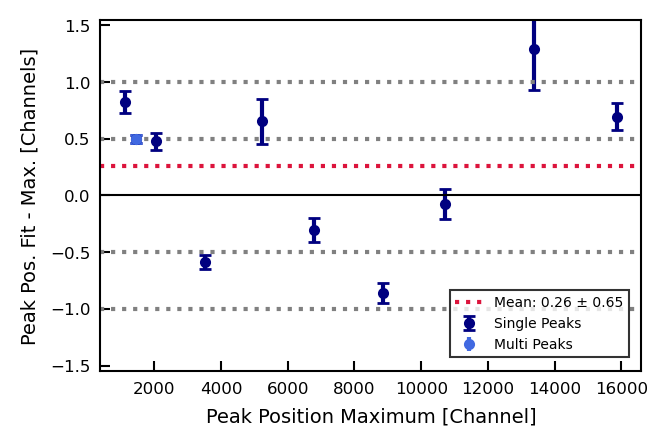

In [60]:
plt.errorbar(df_calibration.channel_max, df_calibration.peak_position-df_calibration.channel_max, 
             yerr = df_calibration.peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'navy', label = 'Single Peaks')
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 df_calibration[df_calibration.name == 'Bi727'].peak_position-df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Bi727'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', 
                 label = 'Multi Peaks')
except:
    pass
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 df_calibration[df_calibration.name == 'Pb238'].peak_position-df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Pb238'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', )
except:
    pass
plt.axhline(y=0, linestyle='-', color = 'k', linewidth = 0.75)
plt.axhline(y=+0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=-0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=+1.0, linestyle='dotted', color = 'gray')
plt.axhline(y=-1.0, linestyle='dotted', color = 'gray')
val_mean_diff = np.mean(df_calibration.peak_position-df_calibration.channel_max)
val_std_diff = np.std(df_calibration.peak_position-df_calibration.channel_max)
plt.axhline(y=val_mean_diff, 
            linestyle='dotted', color = 'crimson', label = 'Mean: '+str(round(val_mean_diff,2))+' ± '+str(round(val_std_diff,2)))
plt.xlabel('Peak Position Maximum [Channel]')
plt.ylabel('Peak Pos. Fit - Max. [Channels]')
val_lim = 1.2*np.max(np.abs(df_calibration.peak_position-df_calibration.channel_max))
val_lim = max(1.5, val_lim)
plt.ylim(-val_lim, +val_lim)

legend = plt.legend(loc=4, bbox_to_anchor=(0.99,0.02), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_deviation_lines_max_fit.png', bbox_inches='tight')
plt.show()

In [61]:
thr = 1.5
outlier_check = np.abs(df_calibration.peak_position-df_calibration.channel_max)>thr
if np.any(outlier_check):
    print('WARNING: For the following peaks, the peak max. and fit positions differ by more than 1 Channel and are hence removed from the following analysis: '+str(df_calibration[outlier_check].name.tolist()))
    df_calibration = df_calibration.drop(df_calibration[outlier_check].index.values)
else:
    print('For all peaks, the peak max. and fit positions differ by less than '+str(thr)+' Channel. We hence keep them all for the following analysis.')

For all peaks, the peak max. and fit positions differ by less than 1.5 Channel. We hence keep them all for the following analysis.


# Calibration

## Linear fit

In [62]:
popt, pcov = curve_fit(linFunc, df_calibration.peak_position, df_calibration.e_lit, 
                       p0=[np.median(df_calibration.e_lit/df_calibration.peak_position), 0], 
                       bounds=((0, -np.inf),
                               (+np.inf, +np.inf)), 
                       sigma=df_calibration.peak_width, maxfev=10000)
cal_CE_a = popt[0]
print(cal_CE_a)
cal_CE_a_err = np.sqrt(pcov[0, 0])
print(cal_CE_a_err)
cal_CE_b = popt[1]
print('')
print(cal_CE_b)
cal_CE_b_err = np.sqrt(pcov[1, 1])
print(cal_CE_b_err)
cal_CE_cov_ab = pcov[0, 1]
cal_CE = (cal_CE_a, cal_CE_b)

cal_EC_a = 1/cal_CE_a
cal_EC_b = -cal_CE_b/cal_CE_a
cal_EC = (cal_EC_a, cal_EC_b)

with open(filename_suffix_save+'_calibration_parameters.txt', 'w') as writer:
    writer.write("cal_CE_a"+"\n")
    writer.write(str(cal_CE_a)+"\n")
    writer.write("cal_CE_a_err"+"\n")
    writer.write(str(cal_CE_a_err)+"\n")
    writer.write("cal_CE_b"+"\n")
    writer.write(str(cal_CE_b)+"\n")
    writer.write("cal_CE_b_err"+"\n")
    writer.write(str(cal_CE_b_err)+"\n")
    writer.write("cal_CE_cov_ab"+"\n")
    writer.write(str(cal_CE_cov_ab)+"\n")

0.16480422280063092
6.6080792157940646e-06

0.49977182490554006
0.041506566771042835


In [63]:
reconstr_e = linFunc(df_calibration.peak_position, *cal_CE)
df_calibration['reconstr_e'] = reconstr_e
reconstr_e_err = np.sqrt(cal_CE_b_err**2 + (cal_CE_a_err*df_calibration.peak_position)**2 + 2*(df_calibration.peak_position)*cal_CE_cov_ab)
df_calibration['reconstr_e_err'] = reconstr_e_err
residuals_e = reconstr_e - df_calibration.e_lit
residuals_e_err = np.sqrt(reconstr_e_err**2 + (df_calibration.e_err_lit)**2)
print(np.mean(residuals_e))

0.005093588125154725


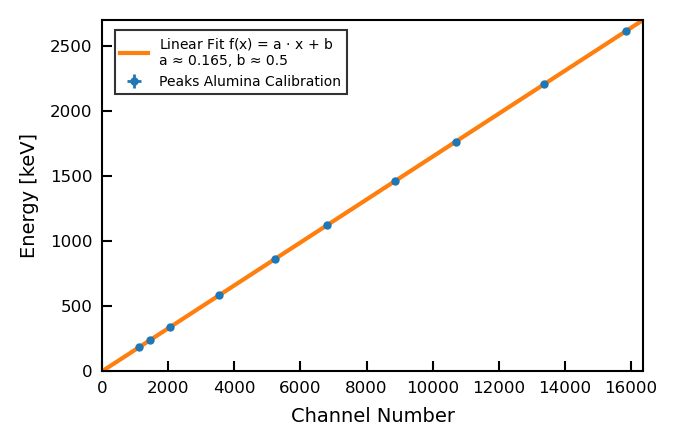

In [64]:
plt.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks Alumina Calibration', linewidth=1)
plt.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],3))+', b ≈ '+str(round(popt[1],3)))
plt.xlabel('Channel Number')
plt.ylabel('Energy [keV]')
#plt.xscale('log'); plt.yscale('log');
plt.xlim(0, 16383)
plt.ylim(0, linFunc(16383, *popt))
legend = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit.png', bbox_inches='tight')
plt.show()

In [65]:
chi2 = np.sum(residuals_e**2 / residuals_e_err**2)
dof = len(residuals_e)-len(popt)

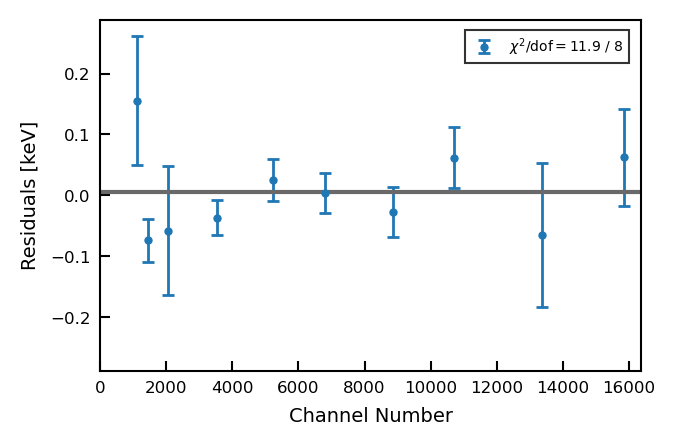

In [66]:
plt.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.xlabel('Channel Number')
plt.ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
plt.xlim(0, 16383)
plt.ylim(-val_lim, val_lim)
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

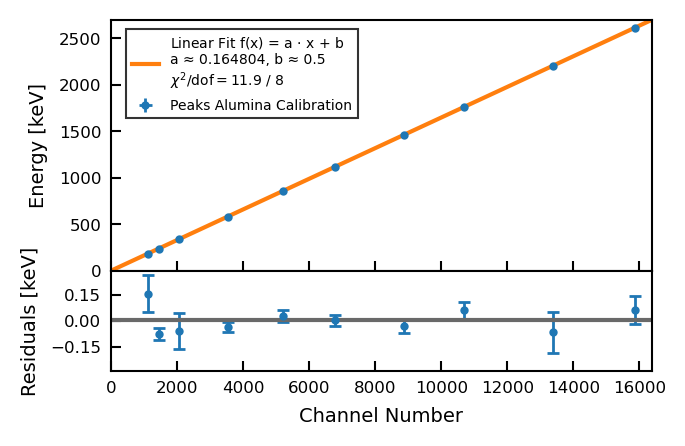

In [67]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks Alumina Calibration', linewidth=1)
ax0.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],6))+', b ≈ '+str(round(popt[1],3))+
         '\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy [keV]')
ax0.set_ylim(0, linFunc(16383, *popt))

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
plt.xlim(0, 16383)

legend = ax0.legend(loc=2, bbox_to_anchor=(0.015,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

In [68]:
print('MCA_ch Residual MCA_ch_error Residual_error')
out = np.array([np.array(df_calibration.peak_position), np.array(residuals_e), 
                np.array(df_calibration.peak_width), np.array(residuals_e_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Residual MCA_ch_error Residual_error
1124.8244698971441 0.15559437343605964 3.3811332979611515 0.106394490162566
1444.4941351212037 -0.07349489637493889 3.0865139231094982 0.03506306213534932
2049.47826358637 -0.05755579795612675 3.2785072011705076 0.10522000308691357
3535.4121654876235 -0.03637396201111187 3.927101650747826 0.02884885824880872
5218.652498621338 0.025740926765820404 4.364917062484984 0.03443745438092608
6794.694759775539 0.004160877232834537 5.032595067834383 0.03272034074106702
8861.139627111961 -0.026998801035233555 5.217855323388941 0.04051479177159386
10703.925355557807 0.0618709635768937 5.739306068582165 0.049649397484079774
13371.291316760433 -0.0649548755664 5.7275732025691335 0.11866985754446546
15861.694141239386 0.06294707318375004 6.71575168432926 0.07966780649996175


In [69]:
print('Energy Residual Energy_error Residual_error')
out = np.array([np.array(df_calibration.e_lit), np.array(-cal_EC_a*residuals_e), 
                np.array(df_calibration.e_err_lit), np.array(cal_EC_a*residuals_e_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

Energy Residual Energy_error Residual_error
185.72 -0.944116423668872 0.1 0.6455810922471016
238.632 0.4459527500326741 0.002 0.21275584775376938
338.32 0.3492373980353276 0.1 0.6384545328926533
583.187 0.22071013347221477 0.002 0.17504926608408652
860.53 -0.1561909417634283 0.02 0.20895978146498226
1120.29 -0.025247394527433235 0.01 0.19854066955948024
1460.88 0.1638234784062232 0.01 0.24583588383293997
1764.49 -0.3754209845201663 0.01 0.3012628963041941
2204.21 0.39413356322172677 0.1 0.7200656362308403
2614.511 -0.38195060851019075 0.01 0.48340876918147


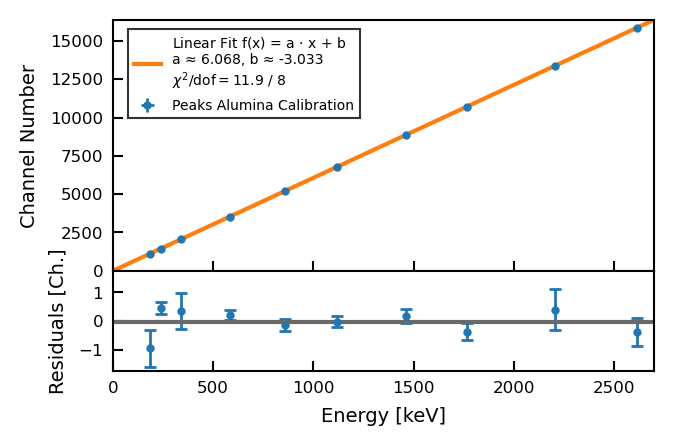

In [70]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, df_calibration.peak_position, 
             yerr = df_calibration.peak_width, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks Alumina Calibration', linewidth=1)
ax0.plot(np.linspace(0,2700,10), linFunc(np.linspace(0,2700,10), *cal_EC), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(cal_EC[0],3))+', b ≈ '+str(round(cal_EC[1],3))+
         '\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Channel Number')
ax0.set_ylim(0, 16383)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, -cal_EC_a*residuals_e, yerr = cal_EC_a*residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(-cal_EC_a*residuals_e), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Residuals [Ch.]')
val_lim = max(np.abs(1.1*np.max(cal_EC_a*(residuals_e+residuals_e_err))), np.abs(1.1*np.min(cal_EC_a*(residuals_e-residuals_e_err))))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_yticks(np.arange(-1, 1.1, step=1))
plt.xlim(0, 2700)

legend = ax0.legend(loc=2, bbox_to_anchor=(0.015,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_inverse_residuals.png', bbox_inches='tight')
plt.show()

## Spectrum

In [71]:
isotope_list = []
for i in df_calibration['name']:
    if i.find('Tl') > -1:
        isotope_list.append('$^{208}$Tl')
    elif i.find('Bi') > -1:
        isotope_list.append('$^{214}$Bi')
    elif i.find('Pb') > -1:
        isotope_list.append('$^{212}$Pb')
    elif i.find('Ac') > -1:
        isotope_list.append('$^{228}$Ac')
    elif i.find('U') > -1:
        isotope_list.append('$^{235}$U')
    elif i.find('K') > -1:
        isotope_list.append('$^{40}$K')
    else:
        isotope_list.append('?')
df_calibration['isotope'] = isotope_list

In [72]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max,reconstr_e,reconstr_e_err,isotope
0,U185,185.720,0.100,1124.824470,0.093404,3.381133,0.074480,0.900446,1124.0,185.875594,0.036329,$^{235}$U
1,Pb238,238.632,0.002,1444.494135,0.035791,3.086514,0.028334,2.159122,1444.0,238.558505,0.035006,$^{212}$Pb
2,Ac338,338.320,0.100,2049.478264,0.075015,3.278507,0.057991,1.064492,2049.0,338.262444,0.032730,$^{228}$Ac
3,Tl583,583.187,0.002,3535.412165,0.063706,3.927102,0.051598,1.796012,3536.0,583.150626,0.028779,$^{208}$Tl
4,Tl860,860.530,0.020,5218.652499,0.198383,4.364917,0.168316,1.332821,5218.0,860.555741,0.028035,$^{208}$Tl
5,Bi1120,1120.290,0.010,6794.694760,0.105410,5.032595,0.086916,1.279259,6795.0,1120.294161,0.031155,$^{214}$Bi
6,K1460,1460.880,0.010,8861.139627,0.088668,5.217855,0.071575,1.756352,8862.0,1460.853001,0.039261,$^{40}$K
7,Bi1764,1764.490,0.010,10703.925356,0.132503,5.739306,0.111216,1.058552,10704.0,1764.551871,0.048632,$^{214}$Bi
8,Bi2204,2204.210,0.100,13371.291317,0.362399,5.727573,0.313913,1.069671,13370.0,2204.145045,0.063895,$^{214}$Bi
9,Tl2614,2614.511,0.010,15861.694141,0.117573,6.715752,0.092877,0.739170,15861.0,2614.573947,0.079038,$^{208}$Tl


In [73]:
np.unique(df_calibration['isotope'])

array(['$^{208}$Tl', '$^{212}$Pb', '$^{214}$Bi', '$^{228}$Ac',
       '$^{235}$U', '$^{40}$K'], dtype=object)

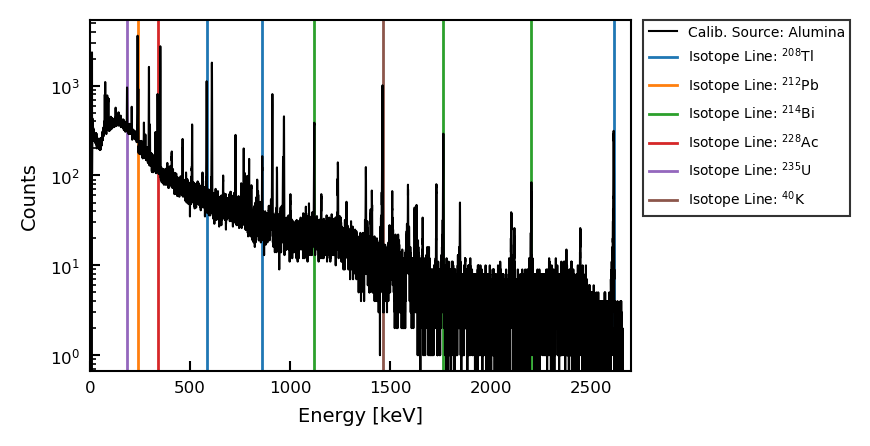

In [74]:
plt.plot(linFunc(df.channel, *cal_CE), df.counts, color = 'black', linewidth = 0.75, label = 'Calib. Source: Alumina')
for j, isot in enumerate(np.unique(df_calibration['isotope'])):
    for i, line in enumerate(df_calibration[df_calibration['isotope'] == isot].e_lit):
        if i == 0:
            plt.axvline(x = line, color = 'C'+str(j), label = 'Isotope Line: '+isot, zorder = 0, linewidth = 1)
        else:
            plt.axvline(x = line, color = 'C'+str(j), zorder = 0, linewidth = 1)

plt.yscale('log')
plt.xlim(0,linFunc(16383, *cal_CE))
#plt.ylim(bottom = 30)
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.02), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_spectrum_lines_marked.png', bbox_inches='tight')
plt.show()

# Resolution

In [75]:
df_calibration = df_calibration[df_calibration.e_lit > 200]

In [76]:
ratio_width_fitlit = cal_CE_a*df_calibration.peak_width/df_calibration.e_err_lit
ratio_width_fitlit

1    254.335264
2      5.403118
3    323.601468
4     35.967838
5     82.939292
6     85.992459
7     94.586188
8      9.439283
9    110.678424
dtype: float64

In [77]:
df_calibration.peak_width

1    3.086514
2    3.278507
3    3.927102
4    4.364917
5    5.032595
6    5.217855
7    5.739306
8    5.727573
9    6.715752
Name: peak_width, dtype: float64

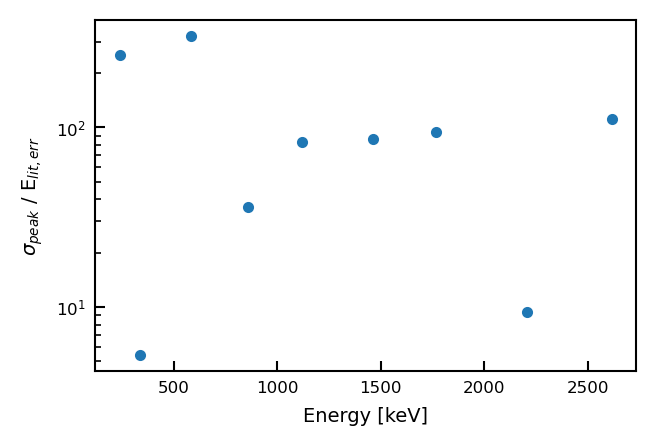

In [78]:
plt.errorbar(df_calibration.e_lit, ratio_width_fitlit, 
            fmt = 'o', ms = 3)
#plt.axhline(y = 20, color = 'gray')
plt.yscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('$\sigma_{peak}$ / E$_{lit, err}$')
plt.show()

In [79]:
reconstr_e = df_calibration['reconstr_e']
reconstr_e_err = df_calibration['reconstr_e_err']

In [80]:
## Remove lines where ratio_width_fitlit<20
#reconstr_e = reconstr_e[ratio_width_fitlit>20]
#reconstr_e_err = reconstr_e_err[ratio_width_fitlit>20]

In [81]:
rel_resol = cal_CE_a*df_calibration.peak_width / reconstr_e
rel_resol_err = rel_resol*np.sqrt((reconstr_e_err/reconstr_e)**2+(cal_CE_a_err/cal_CE_a)**2+(df_calibration.peak_width_unc/df_calibration.peak_width)**2)

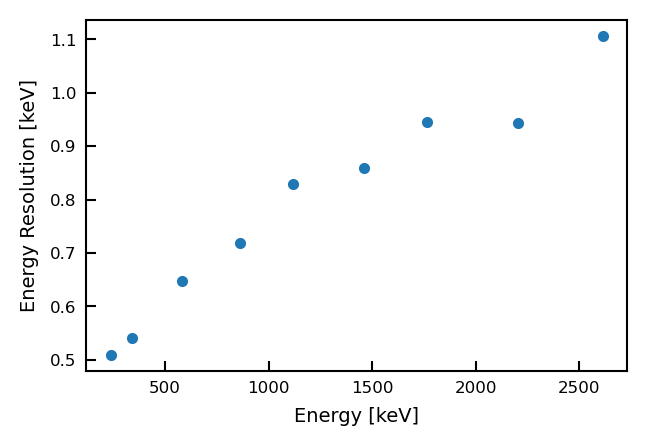

In [82]:
plt.errorbar(df_calibration.e_lit, rel_resol*reconstr_e, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3)
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [keV]')
plt.show()

In [83]:
def relresolFunc(E, a,b,c):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol

In [84]:
popt_relresol, pcov_relresol = curve_fit(relresolFunc, df_calibration.e_lit, rel_resol, 
                       p0=[0.1, 0.1, 0.1], 
                       bounds=((0, 0, 0),
                               (+np.inf, +np.inf, +np.inf)), 
                       sigma=rel_resol_err, maxfev=10000)
print(popt_relresol[0])
print(popt_relresol[1])
print(popt_relresol[2])
print(np.sqrt(np.diag(pcov_relresol)))
reconstr_relresol = relresolFunc(df_calibration.e_lit, *popt_relresol)
residuals = reconstr_relresol - rel_resol
reconstr_relresol_err = 1/2*np.sqrt(popt_relresol[0]**2/df_calibration.e_lit**4 + popt_relresol[1]**2/df_calibration.e_lit**2 + popt_relresol[2]**2)
residuals_err = np.sqrt(reconstr_relresol_err**2 + rel_resol_err**2)
chi2 = np.sum(residuals**2 / residuals_err**2)
dof = len(residuals)-len(popt)

0.1618655342703758
0.0004135499199957963
2.742644386110191e-27
[1.49877505e-02 4.90046611e-05 2.20385529e-08]


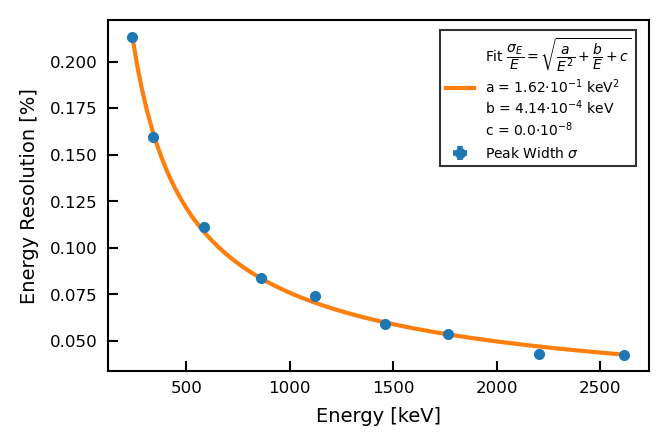

In [85]:
plt.errorbar(df_calibration.e_lit, 100*rel_resol, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol), label = 'Fit $\dfrac{\sigma_E}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(1e1*popt_relresol[0],2))+'$\cdot 10^{-1}$ keV$^2$' 
         +'\nb = '+str(round(1e4*popt_relresol[1],2))+'$\cdot 10^{-4}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$')
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit.png', bbox_inches='tight')
plt.show()

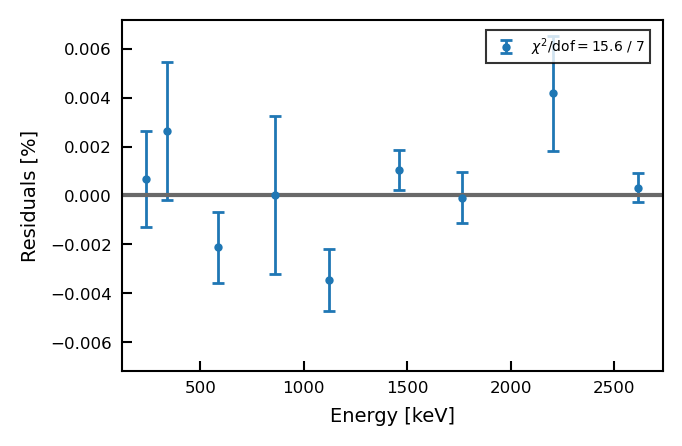

In [86]:
plt.errorbar(df_calibration.e_lit, 100*residuals, yerr = 100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.axhline(y=np.mean(residuals), color = 'dimgray')
plt.xlabel('Energy [keV]')
plt.ylabel('Residuals [%]')
val_lim = max(np.abs(100*1.1*np.max(residuals+residuals_err)), np.abs(100*1.1*np.min(residuals-residuals_err)))
plt.ylim(-val_lim, val_lim)
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals.png', bbox_inches='tight')
plt.show()

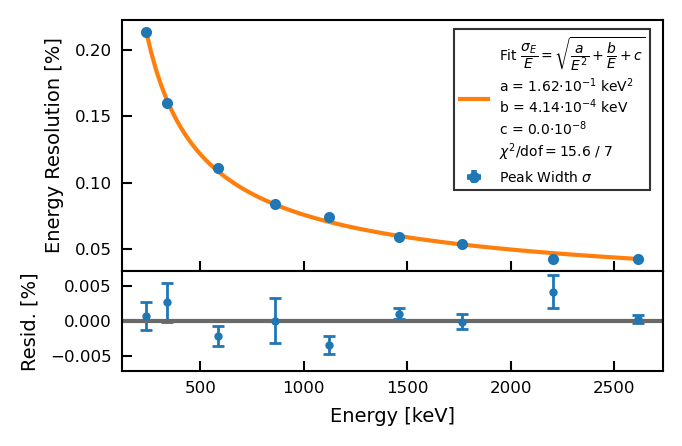

In [87]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, 100*rel_resol, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol), label = 'Fit $\dfrac{\sigma_E}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(1e1*popt_relresol[0],2))+'$\cdot 10^{-1}$ keV$^2$' 
         +'\nb = '+str(round(1e4*popt_relresol[1],2))+'$\cdot 10^{-4}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, 100*residuals, yerr = 100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(100*1.1*np.max(residuals+residuals_err)), np.abs(100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals.png', bbox_inches='tight')
plt.show()

### as function of MCA

In [88]:
resol = df_calibration.peak_width
resol_err = df_calibration.peak_width_unc

In [89]:
def resolFunc(E, a,b,c):
    resol = np.sqrt(a*(E**2) + b*E + c)
    return resol

In [90]:
popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2

(2.742644386110191e-27, 0.0025093405555273985, 5.959608269371968)

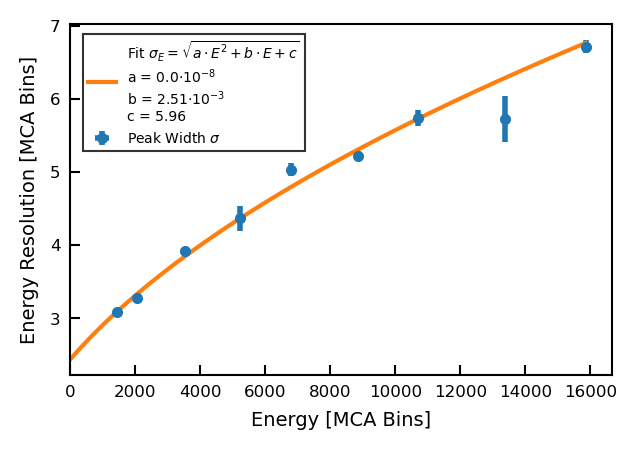

In [91]:
plt.errorbar(df_calibration.peak_position, resol, yerr = resol_err, xerr = df_calibration.peak_position_unc,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = np.linspace(0, np.array(df_calibration.peak_position)[-1], 100)
plt.plot(x_val, resolFunc(x_val, popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2), 
         label = 'Fit $\sigma_E = \sqrt{a \cdot E^2 + b \cdot E +c}$'
         +'\na = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$' 
         +'\nb = '+str(round(1e3*popt_relresol[1]/cal_CE_a,2))+'$\cdot 10^{-3}$' 
         +'\nc = '+str(round(1e0*popt_relresol[0]/cal_CE_a**2,2)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [MCA Bins]')
plt.ylabel('Energy Resolution [MCA Bins]')
plt.xlim(left = 0)
legend = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_ADC.png', bbox_inches='tight')
plt.show()

In [92]:
residuals_conv = residuals*df_calibration.e_lit
residuals_err_conv = residuals_err*df_calibration.e_lit

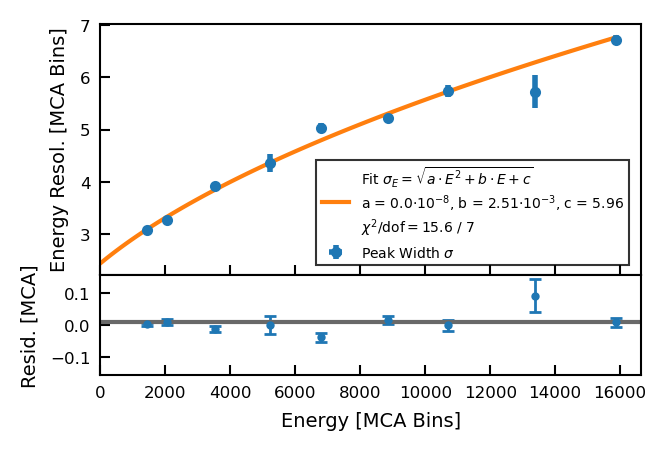

In [93]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.peak_position, resol, yerr = resol_err, xerr = df_calibration.peak_position_unc,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = x_val = np.linspace(0, np.array(df_calibration.peak_position)[-1], 100)
ax0.plot(x_val, resolFunc(x_val, popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2), 
         label = 'Fit $\sigma_E = \sqrt{a \cdot E^2 + b \cdot E +c}$'
         +'\na = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$' 
         +', b = '+str(round(1e3*popt_relresol[1]/cal_CE_a,2))+'$\cdot 10^{-3}$' 
         +', c = '+str(round(1e0*popt_relresol[0]/cal_CE_a**2,2))
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resol. [MCA Bins]')
ax0.set_xlim(left = 0)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.peak_position, residuals_conv, yerr = residuals_err_conv,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals_conv), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [MCA Bins]')
ax1.set_ylabel('Resid. [MCA]')
val_lim = max(np.abs(1.1*np.max(residuals_conv+residuals_err_conv)), np.abs(1.1*np.min(residuals_conv-residuals_err_conv)))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_xlim(left = 0)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=4, bbox_to_anchor=(0.99,0.01), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals_adc.png', bbox_inches='tight')
plt.show()

In [94]:
print('MCA_ch Resolution MCA_ch_error Resolution_error')
out = np.array([np.array(df_calibration.peak_position), np.array(resol), 
                np.array(df_calibration.peak_width), np.array(resol_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Resolution MCA_ch_error Resolution_error
1444.4941351212037 3.0865139231094982 3.0865139231094982 0.028334129932496885
2049.47826358637 3.2785072011705076 3.2785072011705076 0.05799077251025617
3535.4121654876235 3.927101650747826 3.927101650747826 0.05159812340831771
5218.652498621338 4.364917062484984 4.364917062484984 0.16831564764920368
6794.694759775539 5.032595067834383 5.032595067834383 0.08691581462074555
8861.139627111961 5.217855323388941 5.217855323388941 0.07157541982617124
10703.925355557807 5.739306068582165 5.739306068582165 0.11121556938567065
13371.291316760433 5.7275732025691335 5.7275732025691335 0.31391313201786825
15861.694141239386 6.71575168432926 6.71575168432926 0.09287669277469736


In [95]:
print('MCA_ch Residual MCA_ch_error Residual_error')
out = np.array([np.array(df_calibration.peak_position), np.array(residuals_conv), 
                np.array(df_calibration.peak_width), np.array(residuals_err_conv)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Residual MCA_ch_error Residual_error
1444.4941351212037 0.0016154891719357932 3.0865139231094982 0.0046885207033471165
2049.47826358637 0.008939244515527509 3.2785072011705076 0.009564146266104943
3535.4121654876235 -0.01238704415502886 3.927101650747826 0.00850786396756859
5218.652498621338 0.0002046388824337852 4.364917062484984 0.027739254786552828
6794.694759775539 -0.03871836795789593 5.032595067834383 0.014325771774540854
8861.139627111961 0.015280825971018552 5.217855323388941 0.011798164678348795
10703.925355557807 -0.0015987429634509635 5.739306068582165 0.01832943433004138
13371.291316760433 0.09210204093019289 5.7275732025691335 0.051736181649586044
15861.694141239386 0.008184717025495218 6.71575168432926 0.015307631475985569


## Resolution FWHM

In [96]:
sigma_to_fwhm = 2*np.sqrt(2*np.log(2))
print('factor Gaussian sigma to FWHM: '+str(sigma_to_fwhm))

factor Gaussian sigma to FWHM: 2.3548200450309493


In [97]:
popt_relresol_fwhm = popt_relresol*sigma_to_fwhm**2
popt_relresol_fwhm

array([8.97573110e-01, 2.29320769e-03, 1.52084498e-26])

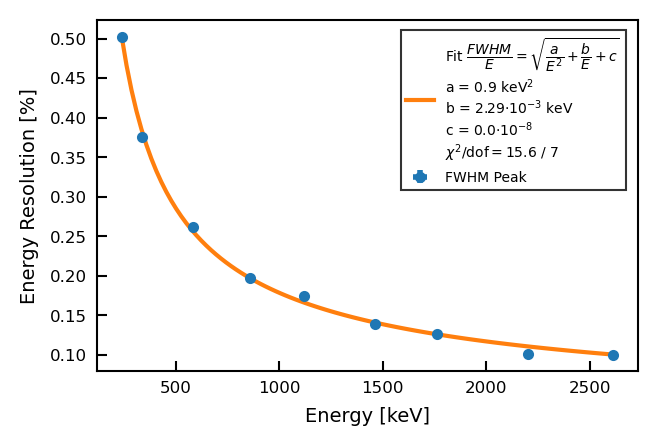

In [98]:
plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit.png', bbox_inches='tight')
plt.show()

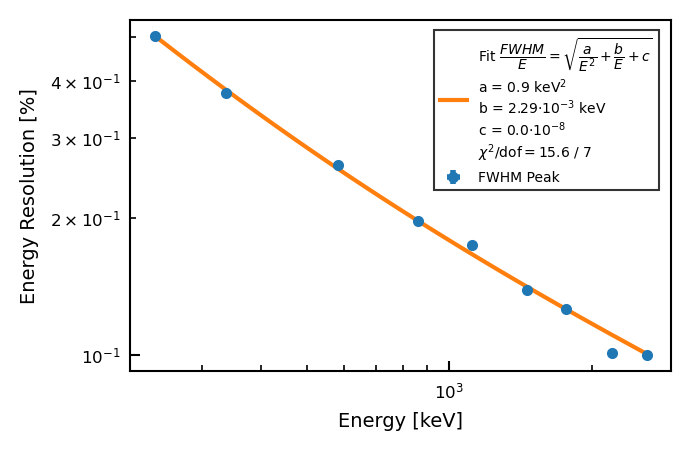

In [99]:
plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_loglog.png', bbox_inches='tight')
plt.show()

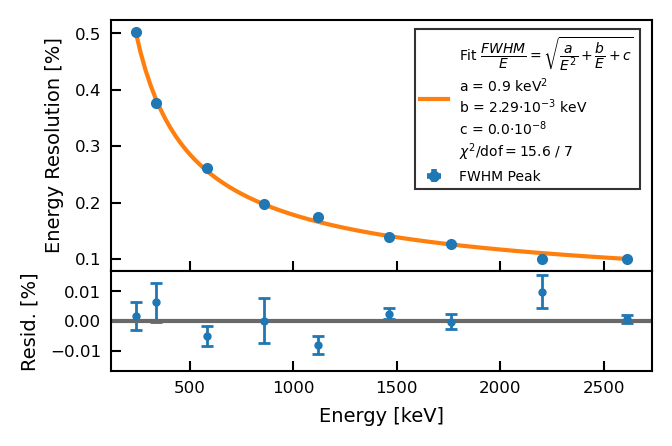

In [100]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*residuals, yerr = sigma_to_fwhm*100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(sigma_to_fwhm*100*1.1*np.max(residuals+residuals_err)), np.abs(sigma_to_fwhm*100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_residuals.png', bbox_inches='tight')
plt.show()

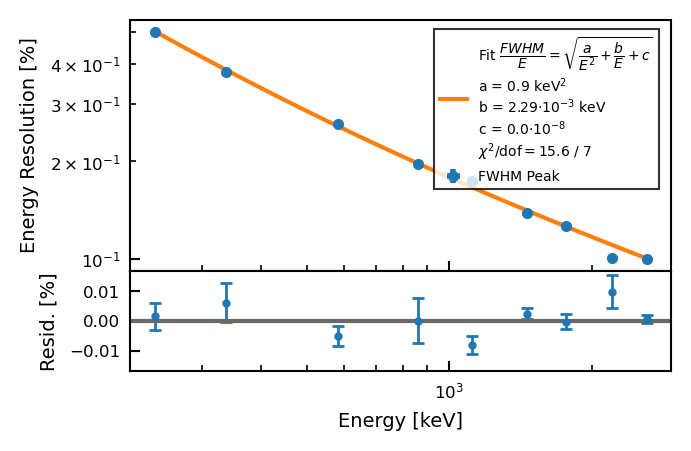

In [101]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')
ax0.set_xscale('log'); ax0.set_yscale('log');

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*residuals, yerr = sigma_to_fwhm*100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(sigma_to_fwhm*100*1.1*np.max(residuals+residuals_err)), np.abs(sigma_to_fwhm*100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)
ax1.set_xscale('log'); 

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_residuals_loglog.png', bbox_inches='tight')
plt.show()

In [102]:
'''matplotlib.rcParams['figure.figsize'] = (3.4908516673585166/1.2, 2.327234444905678)

plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_aspectratio.png', bbox_inches='tight')
plt.show()''';

# Other Stuff

In [103]:
print(cal_CE)
print(cal_EC)

(0.16480422280063092, 0.49977182490554006)
(6.067805684868481, -3.032518320298931)


In [104]:
linFunc(np.array([100, 2700]), *cal_EC)

array([  603.74805017, 16380.04283082])

In [105]:
linFunc(np.array([0, 16383]), *cal_CE)

array([4.99771825e-01, 2.70048735e+03])

In [106]:
cal_20210211_CE_a = 0.16466821456875116
cal_20210211_CE_b = 0.5929430439613557
cal_20210211_CE = (cal_20210211_CE_a, cal_20210211_CE_b)
cal_20210211_EC_a = 1/cal_20210211_CE_a
cal_20210211_EC_b = -cal_20210211_CE_b/cal_20210211_CE_a
cal_20210211_EC = (cal_20210211_EC_a, cal_20210211_EC_b)

def func_e_to_adc(x = np.array([100, 2700]), a = cal_20210211_EC_a, b = cal_20210211_EC_b):
    res = a*x+b
    return res
def func_adc_to_e(x = np.array([0, 16383]), a = cal_20210211_CE_a, b = cal_20210211_CE_b):
    res = a*x+b
    return res

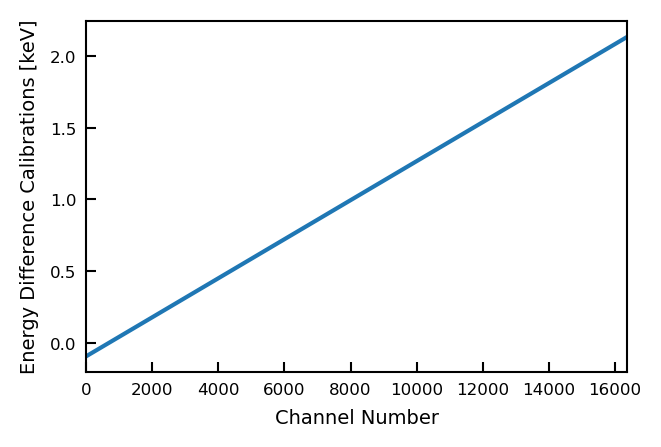

In [107]:
x_list = np.linspace(0,16383,10)
plt.plot(x_list, linFunc(x_list, *popt) - func_adc_to_e(x_list))
plt.xlim(0,16383)
plt.xlabel('Channel Number')
plt.ylabel('Energy Difference Calibrations [keV]')
if save_plots:
    plt.savefig(filename_suffix_save+'_diff_to_calib20210211.png', bbox_inches='tight')
plt.show()

In [108]:
p_resol_20210211 = (0.17847314121118837, 0.0003795669186800097, 2.2915224861410103e-08)

def relresolFunc_old(E, a=p_resol_20210211[0], b=p_resol_20210211[1], c=p_resol_20210211[2]):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol

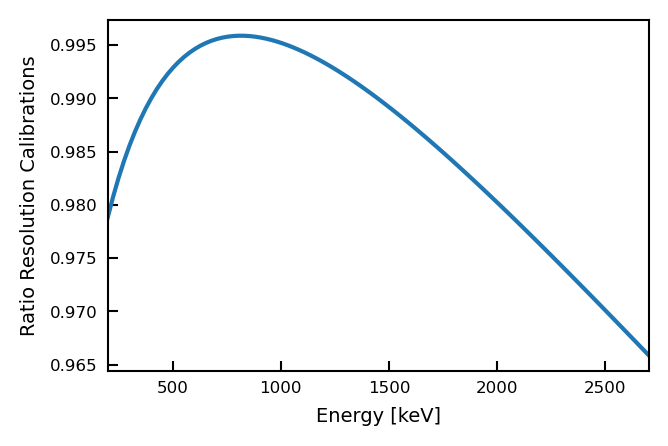

In [109]:
x_list = np.linspace(200,2700,100)

plt.plot(x_list, relresolFunc(x_list, *popt_relresol) / relresolFunc_old(x_list))
plt.xlim(200,2700)
plt.xlabel('Energy [keV]')
plt.ylabel('Ratio Resolution Calibrations')
if save_plots:
    plt.savefig(filename_suffix_save+'_ratioresol_to_calib20210211.png', bbox_inches='tight')
plt.show()

**Resolution to quote:**

In [110]:
1332.49 * relresolFunc(1332.49, *popt_relresol_fwhm)

1.9882780043444845

consistent with previous calibration